# Additional Insights
This notebook delves into supplementary analyses and considerations that, while not included in our primary framework, significantly contribute to the depth and comprehensiveness of our data analysis. 

In [2]:
%run 06_model_building.ipynb

-------------------------------------------------------
The summary for the Model_White Wine Poor (Without Outliers):

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     11.69
Date:                Wed, 22 Nov 2023   Prob (F-statistic):           3.67e-16
Time:                        18:19:48   Log-Likelihood:                -443.99
No. Observations:                1308   AIC:                             906.0
Df Residuals:                    1299   BIC:                             952.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---

## 1. Gridsearch Model creation

Firstly, we decided to create the Grid seach with cross-validation to find the best model for each of our datasets, but after realising that SciKit Learn doesn't provide statistical analysis of the model we had to  recreate the Linear Model using scipy library.

###  Function: evaluate_GS_model

**Parameters:**
*   `pipe` - the pipeline through which we pass
*   `X_train`, `y_train`, `X_test`, `y_test` - data
*   `classifier_params` - hyperparameters for the evaluated model
*   `pipeline_name`
*   `cv` - type of cross-validation (StratifiedKFold 5-fold)

We define a `GridSearchCV` refitting on `r2`.
- Fit the model.
- Predict test data.
- Extract the mean `r2` from cross-validation.
- Select the model with the best parameters.
- Save the results to a dataframe.
- Calculate the score matrix **(since SciKit Learn doesn't provide the statistical analysis of the model we tried to recreate it using stats library)**


In [3]:
def evaluate_GS_model(
    pipe,
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    regression_params,
    pipeline_name,
    cv=KFold(n_splits=5),
    predict_test=True,
    predict_train=True,
):
    """
    Evaluate a machine learning model using grid search with cross-validation.

    Parameters:
    - pipe (sklearn.pipeline.Pipeline): The machine learning pipeline to evaluate.
    - X_train, y_train, X_test, y_test (pandas.DataFrame): Training and testing datasets.
    - regression_params (dict): Parameter grid for grid search.
    - pipeline_name (str): Name of the machine learning pipeline.
    - cv (sklearn.model_selection._split): Cross-validation strategy (default: KFold with 5 splits).
    - predict_test (bool): Whether to predict and evaluate on the test set.
    - predict_train (bool): Whether to predict and evaluate on the training set.

    Returns:
    - tuple: Results DataFrame and Evaluation Matrix DataFrame.
    """
    
    # define grid search
    grid_search_model = GridSearchCV(
        pipe,
        regression_params,
        cv=cv,
        scoring=["r2", "neg_mean_squared_error", "neg_median_absolute_error"],
        refit="neg_mean_squared_error",
        return_train_score=True,
        verbose=3,
    )

    # fit model
    grid_search_model.fit(X_train, y_train)
    y_test_pred = grid_search_model.predict(X_test) if predict_test else None
    test_score = metrics.mean_squared_error(y_test, y_test_pred) if predict_test else None

    y_train_pred = grid_search_model.predict(X_train) if predict_train else None
    train_score = metrics.mean_squared_error(y_train, y_train_pred) if predict_train else None 

    mean_cv_score = grid_search_model.best_score_

    cv_results_df = pd.DataFrame(grid_search_model.cv_results_).iloc[[grid_search_model.best_index_]]
    cv_splits_scores_df = cv_results_df.filter(regex=r"split\d*_test_mean_squared_error").reset_index(drop=True) 
    
    # getting scores based on the metrics defined in the score
    metrics_results_df = cv_results_df.filter(regex=r"mean_test_*").reset_index(drop=True)

    best_estimator = grid_search_model.best_estimator_.named_steps[pipe.steps[-1][0]]

    coefficients = best_estimator.coef_
    intercept = best_estimator.intercept_

    # save results in DataFrame
    this_result = pd.concat(
        [pd.DataFrame({
            "pipeline_name": [pipeline_name],
            "features": [list(X_test.columns)],
            'coef': [coefficients], 
            "train score": [train_score],
            "mean_cv_score": [mean_cv_score],
            "test_score": [test_score],
            "best_model": [grid_search_model.best_estimator_],
            "parameters": [grid_search_model.best_params_],
            }),
            cv_splits_scores_df,
            metrics_results_df,
        ],
        axis=1
    )

    # create DataFrame for the evaluation matrix
    parameters = np.append(intercept, coefficients)
    dataset_column_names = ['Intercept']
    dataset_column_names.extend(list(X_test.columns))
    
    evaluation_matrix_df = pd.DataFrame({
        'df': [pipeline_name for number in range(len(parameters))],
        'const': [pipeline_name for number in range(len(parameters))],
        "Parameters": pd.Series(dataset_column_names),
        "Coefficients": pd.Series(parameters),
    })
    
    return this_result, evaluation_matrix_df


### Define Linear Models using pipelines

* For **y** we take the labels representing the quality of wine form 1 to 10 (1 the lowest score)
* For **X** we select the 8 psychomical features.
* The three pairs of the features that were highly correlated we chose the former, the later or the mean of both. 

In [4]:
#params for our gridsearch
base_steps = [('scaler', StandardScaler())] #normalizing values
lr = ("lr", LinearRegression())
lr_params = dict(lr__fit_intercept=[True, False])

estimators = [(lr, lr_params)]


In [5]:
def building_pipelines(df_lists, features=[top_features_dict, features_among_highly_associated_dict], test_size=0.2, random_state=42):
    """
    Create pipelines and evaluate models for each dataset and feature set.

    Parameters:
    - df_lists (list): List of datasets.
    - features (list): List of feature sets to use in the pipelines.
    - test_size (float): Size of the test set in the train-test split (default: 0.2).
    - random_state (int): Random seed for reproducibility (default: 42).

    Returns:
    - tuple: Pipeline, DataFrame with scores, and a list of evaluation matrices.
    """
    results_df = pd.DataFrame()
    evaluation_matrix_list = []

    # iterate through each dataset
    for dataset in df_lists:
        dataset_name = get_wine_str(dataset)
        
        # iterate through each feature list 
        for feature_set in features:
            # name the pipeline
            pipeline_name = f"Pipeline_{dataset_name}"

            # create X and y sets
            y = dataset['quality']
            X = dataset[feature_set[dataset_name]]

            # train-test split
            X_train, X_test, y_train, y_test = train_test_split(
                X, 
                y, 
                test_size=test_size, 
                random_state=random_state
            )

            # GridSearch 
            for (estimator, params) in estimators:
                print(f"Evaluating {estimator}\n")

                # create a pipeline from the base steps list and estimator
                pipe = Pipeline(base_steps + [estimator])

                this_results, evaluation_matrix = evaluate_GS_model(
                    pipe=pipe,
                    pipeline_name=pipeline_name,
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test,
                    regression_params=params,
                    predict_test=True,
                    predict_train=True,
                    cv=StratifiedKFold(n_splits=5)
                )
                results_df = pd.concat([results_df, this_results], ignore_index=True)

                evaluation_matrix_list.append([evaluation_matrix])

    return pipe, results_df, evaluation_matrix_list


### Testing pipeline on our datasets

In [7]:
pipe, results_df, evaluation_matrix_list = building_pipelines(wine_quality_without_outliers_dfs)

Evaluating ('lr', LinearRegression())

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END lr__fit_intercept=True; neg_mean_squared_error: (train=-0.113, test=-0.116) neg_median_absolute_error: (train=-0.113, test=-0.117) r2: (train=0.079, test=0.089) total time=   0.0s
[CV 2/5] END lr__fit_intercept=True; neg_mean_squared_error: (train=-0.113, test=-0.118) neg_median_absolute_error: (train=-0.112, test=-0.110) r2: (train=0.082, test=0.073) total time=   0.0s
[CV 3/5] END lr__fit_intercept=True; neg_mean_squared_error: (train=-0.112, test=-0.121) neg_median_absolute_error: (train=-0.113, test=-0.102) r2: (train=0.082, test=0.068) total time=   0.0s
[CV 4/5] END lr__fit_intercept=True; neg_mean_squared_error: (train=-0.114, test=-0.115) neg_median_absolute_error: (train=-0.113, test=-0.128) r2: (train=0.093, test=0.017) total time=   0.0s
[CV 5/5] END lr__fit_intercept=True; neg_mean_squared_error: (train=-0.115, test=-0.108) neg_median_absolute_error: (train=-0.116

/usr/local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 2/5] END lr__fit_intercept=False; neg_mean_squared_error: (train=-41.052, test=-41.138) neg_median_absolute_error: (train=-6.193, test=-6.188) r2: (train=-117.029, test=-115.828) total time=   0.0s
[CV 3/5] END lr__fit_intercept=False; neg_mean_squared_error: (train=-41.055, test=-41.067) neg_median_absolute_error: (train=-6.180, test=-6.193) r2: (train=-117.039, test=-115.628) total time=   0.0s
[CV 4/5] END lr__fit_intercept=False; neg_mean_squared_error: (train=-41.073, test=-41.279) neg_median_absolute_error: (train=-6.178, test=-6.195) r2: (train=-116.042, test=-120.540) total time=   0.0s
[CV 5/5] END lr__fit_intercept=False; neg_mean_squared_error: (train=-41.065, test=-40.801) neg_median_absolute_error: (train=-6.186, test=-6.158) r2: (train=-116.699, test=-116.318) total time=   0.0s
Evaluating ('lr', LinearRegression())

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END lr__fit_intercept=True; neg_mean_squared_error: (train=-0.308, test=-0.313) neg_

/usr/local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 3/5] END lr__fit_intercept=True; neg_mean_squared_error: (train=-0.309, test=-0.308) neg_median_absolute_error: (train=-0.403, test=-0.398) r2: (train=0.111, test=0.125) total time=   0.0s
[CV 4/5] END lr__fit_intercept=True; neg_mean_squared_error: (train=-0.312, test=-0.299) neg_median_absolute_error: (train=-0.400, test=-0.386) r2: (train=0.112, test=0.118) total time=   0.0s
[CV 5/5] END lr__fit_intercept=True; neg_mean_squared_error: (train=-0.308, test=-0.311) neg_median_absolute_error: (train=-0.400, test=-0.416) r2: (train=0.116, test=0.105) total time=   0.0s
[CV 1/5] END lr__fit_intercept=False; neg_mean_squared_error: (train=-41.061, test=-40.973) neg_median_absolute_error: (train=-6.181, test=-6.165) r2: (train=-117.017, test=-115.508) total time=   0.0s
[CV 2/5] END lr__fit_intercept=False; neg_mean_squared_error: (train=-41.052, test=-41.174) neg_median_absolute_error: (train=-6.185, test=-6.183) r2: (train=-117.031, test=-115.931) total time=   0.0s
[CV 3/5] END lr__

### Results of the model:

In [8]:
results_df

,pipeline_name,features,coef,train score,mean_cv_score,test_score,best_model,parameters,mean_test_r2,mean_test_neg_mean_squared_error,mean_test_neg_median_absolute_error
0,Pipeline_White Wine Poor (Without Outliers),"[free sulfur dioxide, volatile acidity, total ...","[0.009804424160145594, -0.059479220409756485, ...",0.113651,-0.115599,0.136677,"(StandardScaler(), LinearRegression())",{'lr__fit_intercept': True},0.065193,-0.115599,-0.111200
1,Pipeline_White Wine Poor (Without Outliers),"[free sulfur dioxide, volatile acidity, residu...","[0.03714960623562699, -0.054436712970111406, 0...",0.115442,-0.117185,0.136345,"(StandardScaler(), LinearRegression())",{'lr__fit_intercept': True},0.051781,-0.117185,-0.118854
2,Pipeline_White Wine Good (Without Outliers),"[alcohol, density, chlorides, total sulfur dio...","[0.02335745624729902, -0.3333242162943174, -0....",0.308168,-0.310040,0.326090,"(StandardScaler(), LinearRegression())",{'lr__fit_intercept': True},0.110858,-0.310040,-0.396855
3,Pipeline_White Wine Good (Without Outliers),"[alcohol, chlorides, total sulfur dioxide, res...","[0.20322606485574776, -0.03970062880296654, 0....",0.308824,-0.310859,0.328447,"(StandardScaler(), LinearRegression())",{'lr__fit_intercept': True},0.108493,-0.310859,-0.401499
4,Pipeline_Red Wine Poor (Without Outliers),"[volatile acidity, total sulfur dioxide, pH, f...","[-0.09843156489172676, 0.06506705592099327, -0...",0.107697,-0.111995,0.083575,"(StandardScaler(), LinearRegression())",{'lr__fit_intercept': True},0.066067,-0.111995,-0.101692
5,Pipeline_Red Wine Poor (Without Outliers),"[volatile acidity, total sulfur dioxide, pH, c...","[-0.09738634750601527, 0.06258791750627783, -0...",0.107612,-0.113002,0.082503,"(StandardScaler(), LinearRegression())",{'lr__fit_intercept': True},0.057932,-0.113002,-0.102416
6,Pipeline_Red Wine Good (Without Outliers),"[alcohol, volatile acidity, sulphates, citric ...","[0.1299346089070301, -0.030543707212247258, 0....",0.201659,-0.207719,0.147937,"(StandardScaler(), LinearRegression())",{'lr__fit_intercept': True},0.169862,-0.207719,-0.314700
7,Pipeline_Red Wine Good (Without Outliers),"[alcohol, volatile acidity, sulphates, citric ...","[0.1432220947312403, -0.030493744640852492, 0....",0.200962,-0.206721,0.147073,"(StandardScaler(), LinearRegression())",{'lr__fit_intercept': True},0.173800,-0.206721,-0.311507


### Discussion:

For each of datasets we identify the most suitable dataset: 

**White Poor Wine (N=1639)** (1)
* r2 on the test = 0.136345
* Features: Volatile Acidity, Free Sulfur Dioxide, Residual Sugar, Alcohol, Total Sulfur Dioxide, Fixed Acidity, Density, Citric Acid.

**White Good Wine (N=3249)** (3)
* r2 on the test = 0.328447
* Features: Alcohol, Density, Chlorides, Total Sulfur Dioxide, Residual Sugar, pH, Fixed Acidity

**Red Poor Wine (N=741)** (4) 
* r2 on the test = 0.083575
* Features: Volatile Acidity, Total Sulfur Dioxide, pH, Citric Acid, Alcohol, Sulphates, Density, Residual Sugar.

**Red Good Wine (N=851)** (6)
* r2 on the test = 0.147937
* Features: Alcohol, volatile acidity, sulphates, chlorides, total sulfur dioxide, residual sugar, pH

**Comment**: Overall, we can say that the models don't predict quality very much, r2 suggest that they describe between 13% to 32% of variance.

### When it comes to Intercept and coeficients scores of the model there are presented below: 

e.g. Pipeline_White Wine Poor (Without Outliers)

In [9]:
evaluation_matrix_list[1][0]

,df,const,Parameters,Coefficients
0,Pipeline_White Wine Poor (Without Outliers),Pipeline_White Wine Poor (Without Outliers),Intercept,4.882263
1,Pipeline_White Wine Poor (Without Outliers),Pipeline_White Wine Poor (Without Outliers),free sulfur dioxide,0.037150
2,Pipeline_White Wine Poor (Without Outliers),Pipeline_White Wine Poor (Without Outliers),volatile acidity,-0.054437
3,Pipeline_White Wine Poor (Without Outliers),Pipeline_White Wine Poor (Without Outliers),residual sugar,0.022813
4,Pipeline_White Wine Poor (Without Outliers),Pipeline_White Wine Poor (Without Outliers),alcohol,-0.017102
5,Pipeline_White Wine Poor (Without Outliers),Pipeline_White Wine Poor (Without Outliers),fixed acidity,-0.024791
6,Pipeline_White Wine Poor (Without Outliers),Pipeline_White Wine Poor (Without Outliers),citric acid,0.016143
7,Pipeline_White Wine Poor (Without Outliers),Pipeline_White Wine Poor (Without Outliers),chlorides,-0.007053
8,Pipeline_White Wine Poor (Without Outliers),Pipeline_White Wine Poor (Without Outliers),sulphates,0.003767


**Comment:** based on the coeddicient we can say that the most importnat feature for White poor wine quality prediction is volatile acidity (|score| = 0.05). However, because the model doesn't provide statistical calcualtion od t value and p-value, we don't know if the score is significant.

## 2. Feature Importance using Random Forest

Besides using the Linear Regression Model, we realized later on that it might be a better idea to use Random Forest to identify important features in our recipes.

The following code is a rudimentary attempt to train a Random Forest Classifier without tuning hyperparameters and visualize the importance of various features in predicting wine quality.

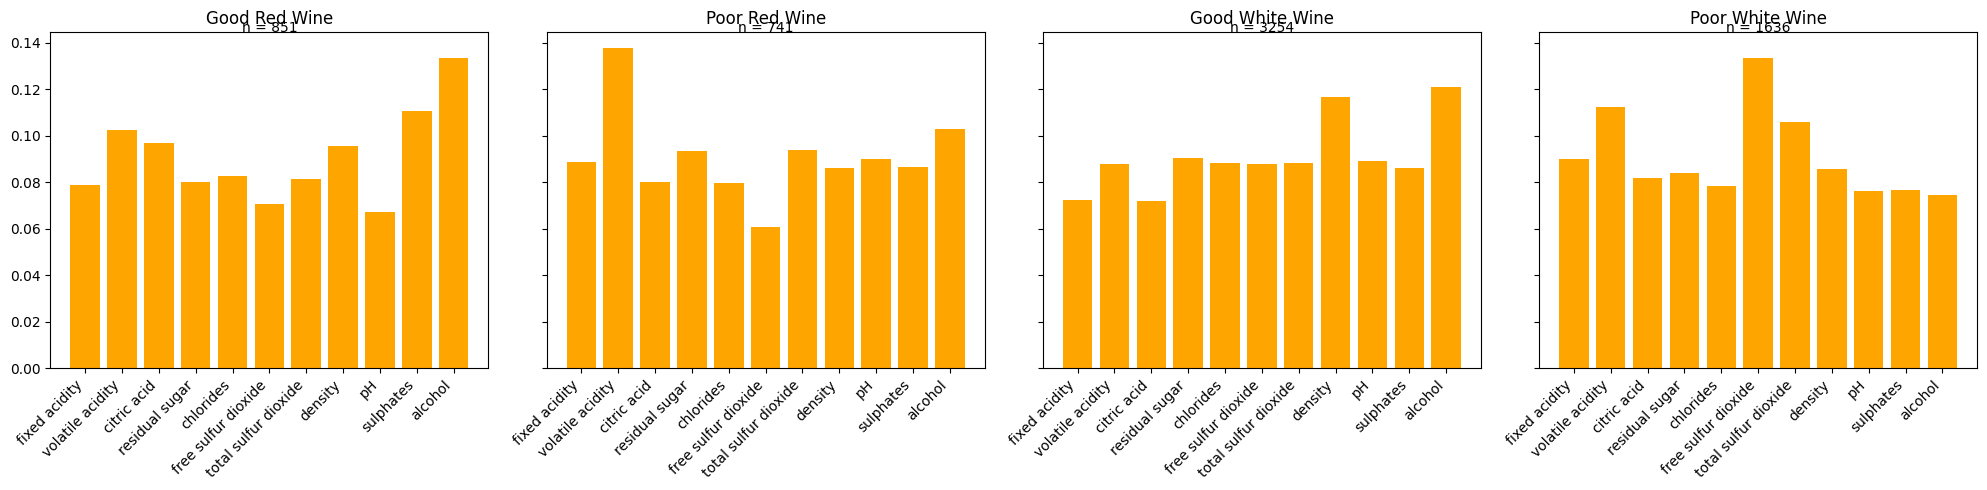

In [11]:
from sklearn.ensemble import RandomForestClassifier

def get_feature_importances(dataframe):
    """
    Calculate feature importances using a RandomForestClassifier.

    Parameters:
    - dataframe (pandas.DataFrame): The dataset to analyze.

    Returns:
    - tuple: A tuple containing the feature importances and the names of the numeric columns.
    """
    numeric_columns = dataframe.select_dtypes(include=np.number).columns.tolist()
    if 'quality' in numeric_columns:
        numeric_columns.remove('quality')
    X = dataframe[numeric_columns]
    y = dataframe['quality']
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)
    return rf.feature_importances_, numeric_columns


good_red_importances, good_red_columns = get_feature_importances(df_red_good_without_outliers)
poor_red_importances, poor_red_columns = get_feature_importances(df_red_poor_without_outliers)
good_white_importances, good_white_columns = get_feature_importances(df_white_good_without_outliers)
poor_white_importances, poor_white_columns = get_feature_importances(df_white_poor_without_outliers)

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
axes[0].bar(good_red_columns, good_red_importances, color = 'orange')
axes[1].bar(poor_red_columns, poor_red_importances, color = 'orange')
axes[2].bar(good_white_columns, good_white_importances, color = 'orange')
axes[3].bar(poor_white_columns, poor_white_importances, color = 'orange')

for i, df, columns in zip(range(4), 
                          [df_red_good_without_outliers, df_red_poor_without_outliers, df_white_good_without_outliers, df_white_poor_without_outliers], 
                          [good_red_columns, poor_red_columns, good_white_columns, poor_white_columns]):
    axes[i].set_title(f"{'Good' if i%2 == 0 else 'Poor'} {'Red' if i < 2 else 'White'} Wine")
    axes[i].set_xticks(range(len(columns)))
    axes[i].set_xticklabels(columns, rotation=45, ha="right")
    axes[i].annotate(f"n = {len(df)}", xy=(0.5, 1), xycoords='axes fraction', ha='center')

plt.tight_layout()
plt.show()